# Online Evaluation
* evaluation with endpoint deployed with vllm

In [1]:
import asyncio
from enum import Enum
import json
import os
import requests
from typing import Optional, Dict, Any, List
import yaml

from openai import OpenAI, AsyncOpenAI
import outlines
from outlines import models, generate
import pandas as pd
import pprint
from pydantic import BaseModel
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm.asyncio import tqdm

from config import experiment_settings

In [2]:
RUN_NAME="qwen2_5-3b-baseline"

# 1. Preparation

## 1-1. OpenAI Client (vllm)

In [3]:
requests.get(f"{experiment_settings.vllm_base_url}/v1/models").json()

{'object': 'list',
 'data': [{'id': 'Qwen/Qwen2.5-3B-Instruct',
   'object': 'model',
   'created': 1745249761,
   'owned_by': 'vllm',
   'root': 'Qwen/Qwen2.5-3B-Instruct',
   'parent': None,
   'max_model_len': 32768,
   'permission': [{'id': 'modelperm-beb134051a2042cda6a24178a2ce9185',
     'object': 'model_permission',
     'created': 1745249761,
     'allow_create_engine': False,
     'allow_sampling': True,
     'allow_logprobs': True,
     'allow_search_indices': False,
     'allow_view': True,
     'allow_fine_tuning': False,
     'organization': '*',
     'group': None,
     'is_blocking': False}]},
  {'id': 'emotion-predictor',
   'object': 'model',
   'created': 1745249761,
   'owned_by': 'vllm',
   'root': '/vllm-workspace/adapter',
   'parent': 'Qwen/Qwen2.5-3B-Instruct',
   'max_model_len': None,
   'permission': [{'id': 'modelperm-65b4de11117c4315871735689d838095',
     'object': 'model_permission',
     'created': 1745249761,
     'allow_create_engine': False,
     'al

In [4]:
# print(f"{experiment_settings.vllm_base_url}/v1")
client = AsyncOpenAI(
    base_url=f"{experiment_settings.vllm_base_url}/v1",
    api_key=experiment_settings.vllm_api_key,
)

## 1-2. Prompt

In [5]:
with open("prompts/inference.yaml", "r") as f:
    PROMPTS = yaml.safe_load(f)
SYSTEM_MESSAGE = PROMPTS["system"]
USER_TEMPLATE = PROMPTS["user"]

In [6]:
# Output Schema
class RelationshipStatus(str, Enum):
    na = "na"
    low = "low"
    medium = "medium"
    high = "high"
    
class EmotionLabel(BaseModel):
    joy: RelationshipStatus
    trust: RelationshipStatus
    fear: RelationshipStatus
    surprise: RelationshipStatus
    sadness: RelationshipStatus
    disgust: RelationshipStatus
    anger: RelationshipStatus
    anticipation: RelationshipStatus
        
class EntryResult(BaseModel):
    emotion: EmotionLabel
    reason: str

## 1-3. Test data

In [7]:
llm_model = "gpt-4.1-mini-2025-04-14"
df = pd.read_csv(f"data/comet/test/test_{llm_model}.tsv", sep="\t")
# df = df.sample(10)
print(df.shape, df.columns)

(4452, 16) Index(['uid', 'original_idx', 'original_src', 'original_relation',
       'original_tgt', 'source', 'character', 'joy', 'trust', 'fear',
       'surprise', 'sadness', 'disgust', 'anger', 'anticipation', 'reason'],
      dtype='object')


In [8]:
def make_messages(row):
    user_message = USER_TEMPLATE.format(
        source=row['source'],
        character=row['character']
    )
    assistant_message = json.dumps(
        {
            "emotion": {
                "joy": row['joy'],
                "trust": row['trust'],
                "fear": row['fear'],
                "surprise": row['surprise'],
                "sadness": row['sadness'],
                "disgust": row['disgust'],
                "anger": row['anger'],
                "anticipation": row['anticipation']
            },
            "reason": row['reason']
        }
    )

    messages = [
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": user_message},
        {"role": "assistant", "content": assistant_message}
    ]
    return messages

In [9]:
all_messages = [
    make_messages(df.iloc[i]) for i in range(df.shape[0])
]

## 1-4. Prediction Function

In [12]:
async def predict(messages):
    json_schema = EntryResult.model_json_schema()
    completion = await client.chat.completions.create(
        model="Qwen/Qwen2.5-3B-Instruct",
        messages=messages,
        extra_body={"guided_json": json_schema},
    )
    result = json.loads(completion.choices[0].message.content)
    return result

In [13]:
result = await predict(all_messages[0])

In [14]:
result

{'emotion': {'joy': 'na',
  'trust': 'na',
  'fear': 'na',
  'surprise': 'na',
  'sadness': 'na',
  'disgust': 'na',
  'anger': 'na',
  'anticipation': 'na'},
 'reason': 'James feels neutral and has no emotional reaction to Emma getting something to drink.'}

In [15]:
## Test Batch Prediction
async def predict_with_sem(semaphore, messages):
    async with semaphore:
        return await predict(messages)
    
sem = asyncio.Semaphore(16)
tasks = []

for messages in all_messages[:32]:
    task = asyncio.create_task(predict_with_sem(sem, messages))
    tasks.append(task)
results = await tqdm.gather(*tasks)
print("Results:")
for i, result in enumerate(results):
    print(f"Result {i}: {result}")
    # print(f"Emotion: {result['emotion']}")
    # print(f"Reason: {result['reason']}")
    # print()

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:02<00:00, 11.01it/s]

Results:
Result 0: {'emotion': {'joy': 'na', 'trust': 'na', 'fear': 'na', 'surprise': 'na', 'sadness': 'na', 'disgust': 'na', 'anger': 'na', 'anticipation': 'na'}, 'reason': 'James feels neutral and has no emotional reaction to Emma getting something to drink.'}
Result 1: {'emotion': {'joy': 'na', 'trust': 'na', 'fear': 'low', 'surprise': 'na', 'sadness': 'high', 'disgust': 'na', 'anger': 'low', 'anticipation': 'medium'}, 'reason': 'Michael feels downtrodden due to the heavy workload and looming pressure to improve his project.'}
Result 2: {'emotion': {'joy': 'na', 'trust': 'na', 'fear': 'high', 'surprise': 'na', 'sadness': 'high', 'disgust': 'na', 'anger': 'na', 'anticipation': 'low'}, 'reason': 'Sophia feels depressed because her worries and fears about failing exams overwhelm her.'}
Result 3: {'emotion': {'joy': 'medium', 'trust': 'high', 'fear': 'na', 'surprise': 'na', 'sadness': 'na', 'disgust': 'na', 'anger': 'na', 'anticipation': 'na'}, 'reason': "Lucas's mother feels grateful b

# 2. Predict Test Data

In [16]:
## Test Batch Prediction
async def predict_with_sem(semaphore, messages):
    async with semaphore:
        return await predict(messages)
    
sem = asyncio.Semaphore(16)
tasks = []

for messages in all_messages:
    task = asyncio.create_task(predict_with_sem(sem, messages))
    tasks.append(task)
results = await tqdm.gather(*tasks)
print("Results: {}".format(len(results)))

100%|██████████| 4452/4452 [06:10<00:00, 12.03it/s]

Results: 4452


# 3. Analyze Predictions

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [18]:
labels = ["na", "low", "medium", "high"]
emotion_cols = ["joy", "trust", "fear", "surprise", "sadness", "disgust", "anger", "anticipation"]

reports = {}
for col in emotion_cols:
    y_true = df[col].tolist()
    # y_pred = [getattr(pred.emotion, col).value for pred in predictions]
    y_pred = [pred["emotion"][col] for pred in results]
    reports[col] = classification_report(
        y_true, 
        y_pred,
        labels=labels,
        output_dict=True,
        zero_division=0
    )
reports

{'joy': {'na': {'precision': 0.9959370238699847,
   'recall': 0.9736842105263158,
   'f1-score': 0.9846849108712026,
   'support': 2014.0},
  'low': {'precision': 0.8730769230769231,
   'recall': 0.9956140350877193,
   'f1-score': 0.930327868852459,
   'support': 456.0},
  'medium': {'precision': 0.9976,
   'recall': 0.9704280155642023,
   'f1-score': 0.9838264299802761,
   'support': 1285.0},
  'high': {'precision': 0.9733520336605891,
   'recall': 0.9956958393113343,
   'f1-score': 0.9843971631205674,
   'support': 697.0},
  'accuracy': 0.9784366576819407,
  'macro avg': {'precision': 0.9599914951518742,
   'recall': 0.9838555251223929,
   'f1-score': 0.9708090932061262,
   'support': 4452.0},
  'weighted avg': {'precision': 0.9802970823132652,
   'recall': 0.9784366576819407,
   'f1-score': 0.9788245067185566,
   'support': 4452.0}},
 'trust': {'na': {'precision': 1.0,
   'recall': 0.9736740224545103,
   'f1-score': 0.9866614358571989,
   'support': 2583.0},
  'low': {'precision': 0

In [19]:
categories = emotion_cols
labels = ['na', 'low', 'medium', 'high']

# f1_values = {
#     category: {
#         label: reports[category][label]['f1-score']
#         for label in labels
#     }
#     for category in categories
# }
f1_values = {
    label: [reports[cat][label]['f1-score'] for cat in categories]
    for label in labels
}
f1_values

{'na': [0.9846849108712026,
  0.9866614358571989,
  0.9893814706663128,
  0.9910222082217672,
  0.9843812575090108,
  0.9986000933271115,
  0.9962443665498247,
  0.9928887180472804],
 'low': [0.930327868852459,
  0.9771689497716894,
  0.9365721997300944,
  0.9857936998147004,
  0.8519269776876268,
  0.958904109589041,
  0.9865951742627346,
  0.9808374733853797],
 'medium': [0.9838264299802761,
  0.9865429234338747,
  0.9498910675381264,
  0.979539641943734,
  0.9523809523809523,
  0.9866666666666667,
  0.9797101449275363,
  0.9889746416758545],
 'high': [0.9843971631205674,
  0.971830985915493,
  0.8352941176470589,
  0.8831168831168831,
  0.932475884244373,
  0.8947368421052632,
  0.8383838383838383,
  0.9623430962343096]}

na
[0.9846849108712026, 0.9866614358571989, 0.9893814706663128, 0.9910222082217672, 0.9843812575090108, 0.9986000933271115, 0.9962443665498247, 0.9928887180472804]
low
[0.930327868852459, 0.9771689497716894, 0.9365721997300944, 0.9857936998147004, 0.8519269776876268, 0.958904109589041, 0.9865951742627346, 0.9808374733853797]
medium
[0.9838264299802761, 0.9865429234338747, 0.9498910675381264, 0.979539641943734, 0.9523809523809523, 0.9866666666666667, 0.9797101449275363, 0.9889746416758545]
high
[0.9843971631205674, 0.971830985915493, 0.8352941176470589, 0.8831168831168831, 0.932475884244373, 0.8947368421052632, 0.8383838383838383, 0.9623430962343096]


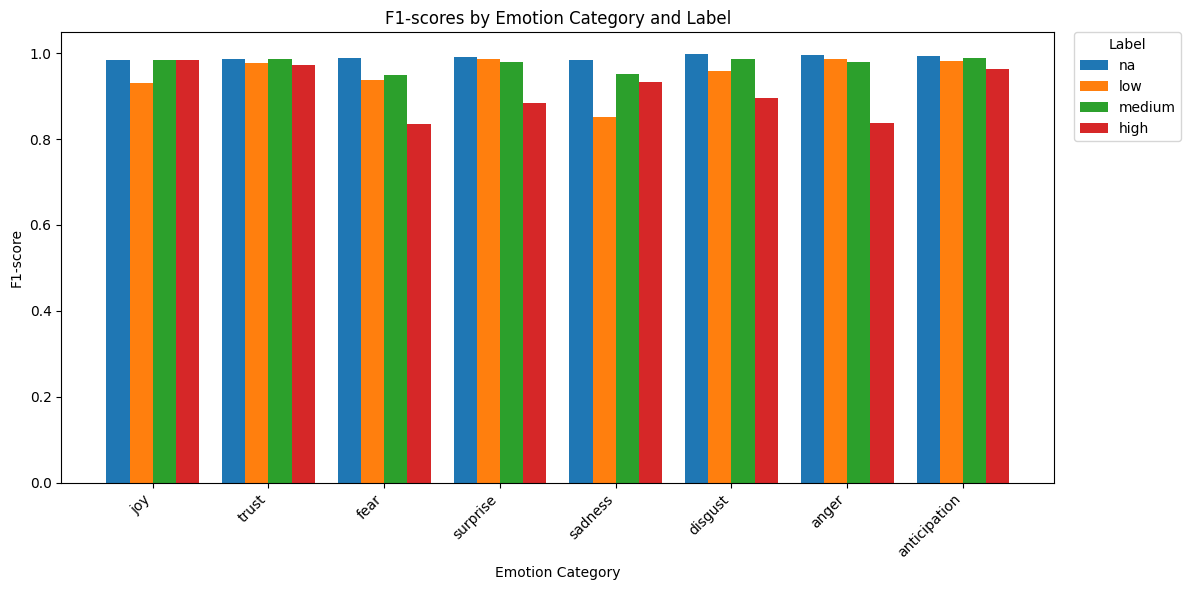

In [20]:
x = np.arange(len(categories))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

# Plot grouped bars
for i, label in enumerate(labels):
    print(label)
    print(f1_values[label])
    ax.bar(x + i * width, f1_values[label], width, label=label)

# Set chart details
ax.set_xticks(x + width * (len(labels) - 1) / 2)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_ylabel('F1-score')
ax.set_xlabel('Emotion Category')
ax.set_title('F1-scores by Emotion Category and Label')
# ax.legend(title='Label')
ax.legend(title='Label', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(f"figs/{RUN_NAME}-f1-scores.png")
plt.show()


In [21]:
# labels = ["na", "low", "medium", "high"]
# for column in ["joy", "trust", "fear", "surprise", "sadness", "disgust", "anger", "anticipation"]:
#     y_true = df[column].tolist()
#     print(df[column].unique())
#     y_pred = [getattr(pred.emotion, column).value for pred in predictions]
#     print(f"Classification report for {column}:")
#     print(classification_report(y_true, y_pred, labels=labels))